<a href="https://colab.research.google.com/github/hanimatari/VR-Fraud-Detection/blob/main/VR_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy openpyxl scikit-learn xgboost matplotlib seaborn streamlit --quiet

from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_excel('VR_FRAUD_DATASET.xlsx', engine='openpyxl')
print(df.shape)
print(df.head())
df.info()
print(df.describe(include='all').T)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


Saving VR_FRAUD_DATASET.xlsx to VR_FRAUD_DATASET.xlsx
(1000, 18)
   step      type  price_paid user_id  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT     9839.64     C18       170136.0       160296.36   
1     1   PAYMENT     1864.28     C25        21249.0        19384.72   
2     1  TRANSFER      181.00     C47          181.0            0.00   
3     1  CASH_OUT      181.00     C51          181.0            0.00   
4     1   PAYMENT    11668.14     C95        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  is_suspicious  isFlaggedFraud  \
0  M1979787155             0.0             0.0              0               0   
1  M2044282225             0.0             0.0              0               0   
2   C553264065             0.0             0.0              1               0   
3    C38997010         21182.0             0.0              1               0   
4  M1230701703             0.0             0.0              0               0   

   market_value

In [2]:
import numpy as np

if 'market_value' not in df:
    df['market_value'] = df['price_paid'] * np.random.uniform(0.8, 1.2, len(df))

df['price_diff'] = df['price_paid'] - df['market_value']
df['overpriced'] = (df['price_diff'] / df['market_value']) > 0.3
df['trans_count'] = df.groupby('user_id')['price_paid'].transform('count')
df['repeat_user'] = df['trans_count'] > 1
df['withdraw'] = df['type'].isin(['CASH_OUT', 'WITHDRAW'])
df['suspicious'] = df['withdraw'] & df['overpriced']

print(df[['market_value', 'price_diff', 'overpriced', 'trans_count', 'repeat_user', 'withdraw', 'suspicious']].head())


   market_value  price_diff  overpriced  trans_count  repeat_user  withdraw  \
0       2732.73     7106.91        True           14         True     False   
1       3268.64    -1404.36       False           12         True     False   
2       1271.87    -1090.87       False            9         True     False   
3       6131.67    -5950.67       False            6         True      True   
4       3865.09     7803.05        True           14         True     False   

   suspicious  
0       False  
1       False  
2       False  
3       False  
4       False  


In [3]:
print(df.isnull().sum())
print(df['overpriced'].value_counts())
print(df['suspicious'].value_counts())


step                      0
type                      0
price_paid                0
user_id                   0
oldbalanceOrg             0
newbalanceOrig            0
nameDest                  0
oldbalanceDest            0
newbalanceDest            0
is_suspicious             0
isFlaggedFraud            0
market_value              0
price_difference          0
is_overpriced             0
user_transaction_count    0
is_repeating_user         0
is_withdrawal             0
suspicious_withdrawal     0
price_diff                0
overpriced                0
trans_count               0
repeat_user               0
withdraw                  0
suspicious                0
dtype: int64
overpriced
True     802
False    198
Name: count, dtype: int64
suspicious
False    774
True     226
Name: count, dtype: int64


In [4]:
df['label'] = df['overpriced'] | df['suspicious']
print(df['label'].value_counts())

maj = df[df['label'] == False]
min = df[df['label'] == True]
print(len(maj), len(min))

min_up = min.sample(n=len(maj), replace=True, random_state=42)
df2 = pd.concat([maj, min_up]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df2.shape, df2['label'].sum(), len(df2) - df2['label'].sum())


label
True     802
False    198
Name: count, dtype: int64
198 802
(396, 25) 198 198


In [5]:
data = df2.drop(['user_id', 'nameDest'], axis=1)
data = pd.get_dummies(data, columns=['type'], drop_first=True)
X = data.drop('label', axis=1)
y = data['label']
print([c for c in X.columns if X[c].dtype == 'object'])


[]


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(X_train.shape, X_test.shape)


(316, 25) (80, 25)


              precision    recall  f1-score   support

       False       1.00      1.00      1.00        40
        True       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        40
        True       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:44:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


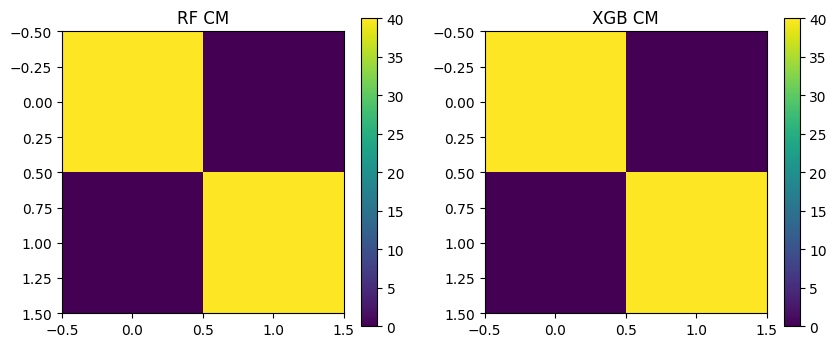

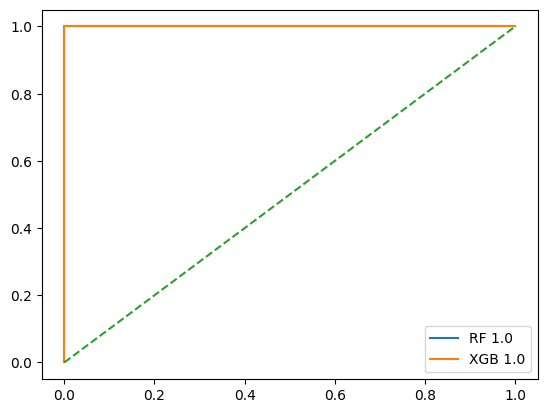

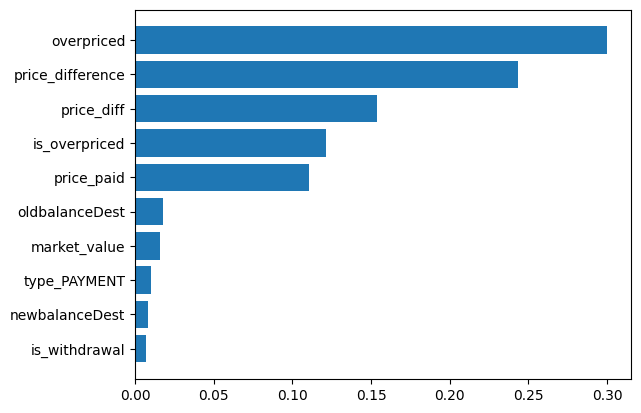

In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))

xg = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xg.fit(X_train, y_train)
pred_xg = xg.predict(X_test)
print(classification_report(y_test, pred_xg))

cm1 = confusion_matrix(y_test, pred_rf)
cm2 = confusion_matrix(y_test, pred_xg)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cm1, interpolation='nearest')
plt.title('RF CM')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cm2, interpolation='nearest')
plt.title('XGB CM')
plt.colorbar()
plt.show()

rf_probs = rf.predict_proba(X_test)[:,1]
xg_probs = xg.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = roc_curve(y_test, rf_probs)
fpr2, tpr2, _ = roc_curve(y_test, xg_probs)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
plt.plot(fpr1, tpr1, label='RF '+str(round(auc1,3)))
plt.plot(fpr2, tpr2, label='XGB '+str(round(auc2,3)))
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

imps = rf.feature_importances_
cols = X_train.columns
idx = sorted(range(len(imps)), key=lambda i: imps[i], reverse=True)[:10]
vals = [imps[i] for i in idx]
labs = [cols[i] for i in idx]
plt.barh(range(len(vals)), vals[::-1])
plt.yticks(range(len(labs)), labs[::-1])
plt.show()


In [8]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(rf, f)

from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>